## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [18]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [19]:
train, test = keras.datasets.cifar10.load_data()

In [20]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [21]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [31]:
def build_mlp(input_shape,output_units=10,num_units=[512,256,128],dropout=False,batch_normalize=False,weight_decay=False):
    input_layer=keras.layers.Input(input_shape)
    for i,n_units in enumerate(num_units):
        if i==0:
            if weight_decay :
                x=keras.layers.Dense(units=n_units,name='hidden_layer'+str(i+1),kernel_regularizer=l2(1e-4))(input_layer)
                if dropout :
                    x=keras.layers.Dropout(0.5)(x)
                    if batch_normalize :
                        x=BatchNormalization()(x)
                else:
                    if batch_normalize :
                        x=BatchNormalization()(x)
            else:
                x=keras.layers.Dense(units=n_units,name='hidden_layer'+str(i+1))(input_layer)
                if dropout :
                    x=keras.layers.Dropout(0.5)(x)
                    if batch_normalize :
                        x=BatchNormalization()(x)
                else:
                    if batch_normalize :
                        x=BatchNormalization()(x)
        else:
            if weight_decay :
                x=keras.layers.Dense(units=n_units,name='hidden_layer'+str(i+1),kernel_regularizer=l2(1e-4))(x)
                if dropout :
                    x=keras.layers.Dropout(0.5)(x)
                    if batch_normalize :
                        x=BatchNormalization()(x)
                else:
                    if batch_normalize :
                        x=BatchNormalization()(x)
            else:
                x=keras.layers.Dense(units=n_units,name='hidden_layer'+str(i+1))(x)
                if dropout :
                    x=keras.layers.Dropout(0.5)(x)
                    if batch_normalize :
                        x=BatchNormalization()(x)
                else:
                    if batch_normalize :
                        x=BatchNormalization()(x)
    
    output_layer=keras.layers.Dense(units=output_units,activation='softmax',name='output_layer')(x)
    model=keras.models.Model(inputs=[input_layer],outputs=[output_layer])
   
    return model

In [32]:
EPOCHS=50
BATCH_SIZE=256
LR=0.0001
MOMENTUM=0.95

BN=[True,False]
DP=[True,False]
WD=[True,False]

In [33]:
results = {}
for i, (bn,dp,wd) in enumerate(itertools.product(BN,DP,WD)):
    print(f"Numbers of exp: {i}, batch_normalize: {bn}, dropout: {dp},L2_regulizer: {wd}")
    model = build_mlp(input_shape=x_train.shape[1:],dropout=dp,batch_normalize=bn,weight_decay=wd)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LR)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}
    

Numbers of exp: 0, batch_normalize: True, dropout: True,L2_regulizer: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
b

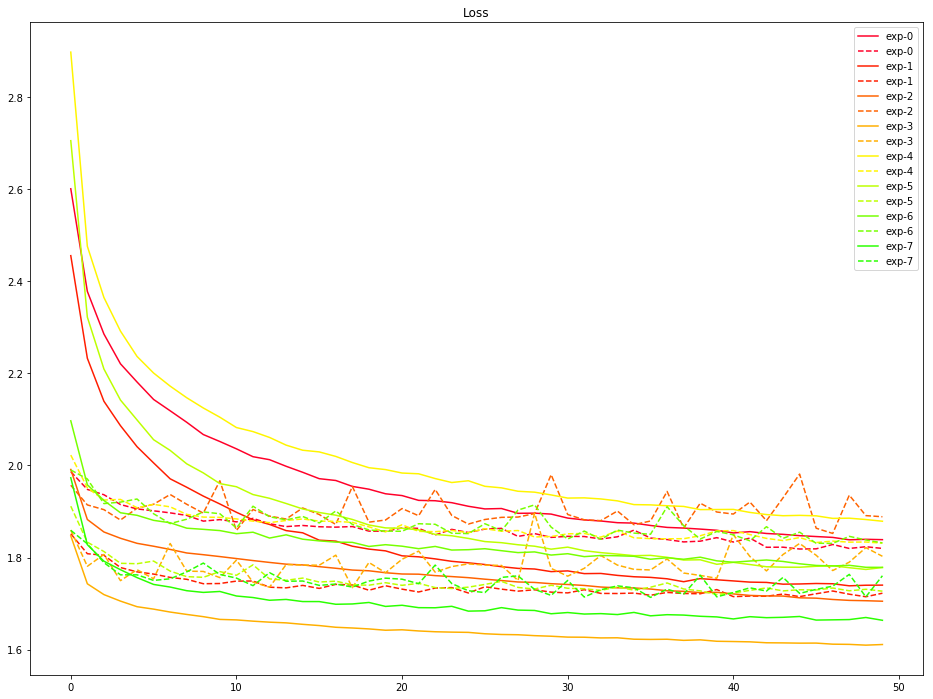

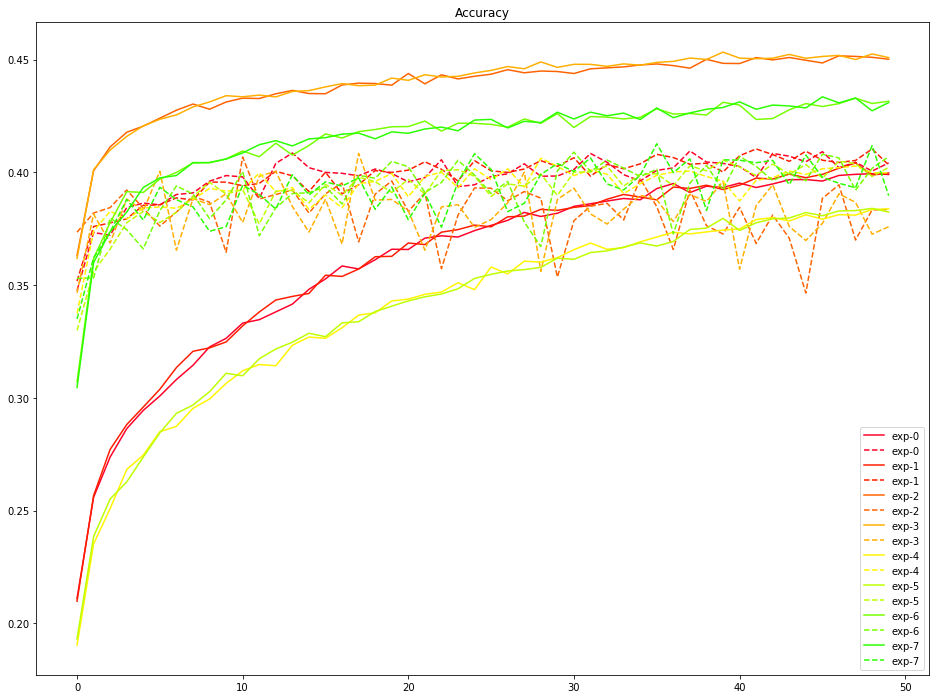

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()